In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split,cross_val_predict, StratifiedGroupKFold, GroupKFold

from pptoolbox.platform.preprocessing import preprocess_v2
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.pipelines import META_REGRESSION_PIPELINES
from pptoolbox.platform.utils import regression_predict
from pptoolbox.utils import load_pf_legacy_models

import glob
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Helper Utils

In [2]:
# Dumping meta utils here. 
# Algorithm design still undergoing testing. not yet stable for pptoolbox?
import warnings
from typing import Literal, Optional
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import BaseCrossValidator, cross_val_predict


AUTOML_MODE_OPTIONS = ["classify", "profile"]

def create_meta_datasets_splits(
    estimators: list[list[Pipeline]],
    datasets: list[pd.DataFrame],
    y: pd.Series,
    groups: np.ndarray,
    outer_cv: BaseCrossValidator,
    inner_cv: BaseCrossValidator,
    mode: Literal[AUTOML_MODE_OPTIONS] = "classify",
) -> tuple[pd.DataFrame, pd.Series, np.ndarray]:
    """
    Custom pre-processing for meta-model cross validation flow
    This flow assumes we maintain the same split indexes across all hyperparams to be tested.
    Because of this, we can pre-calculate the features being input to meta-model
    Instead of re-fitting the same estimator at each fold
    """
    if mode not in AUTOML_MODE_OPTIONS:
        raise ValueError(f"Unexpected mode: {mode}. Expected {AUTOML_MODE_OPTIONS}")
    if len(datasets) == 1:
        raise ValueError(
            "This is meant for data fusion. Check your input is a List of pandas.DataFrame"
        )

    for X in datasets[1:]:
        if len(X) != len(datasets[0]):
            raise IndexError(
                f"Lengths of input datasets do not match ({datasets[0].shape[0]}), ({X.shape[0]})"
            )

    for i, estimator_list in enumerate(estimators):
        if type(estimator_list) != list:
            if type(estimator_list) == Pipeline:
                warnings.warn("Single estimator detected. Converting to list")
                estimators[i] = [estimator_list]
            else:
                raise ValueError("estimators should be a list of lists of Pipelines")

    if len(datasets) != len(estimators):
        raise ValueError(
            "Length of datasets and estimators do not match. Check your inputs"
        )

    if mode == "classify":
        n_classes = len(np.unique(y))
    else:
        n_classes = 1

    n = len(datasets[0])
    m_list = [0] + [len(estimator_list) for estimator_list in estimators]
    m = sum(m_list) * n_classes
    k = outer_cv.get_n_splits()

    new_indices = np.concatenate([datasets[0].index] * k)
    meta_X = np.zeros((n * k, m))
    meta_y = pd.Series(np.concatenate([y] * k), index=new_indices)
    splits_idx = np.zeros((n * k, 2))

    for fold_idx, (train_idx, test_idx) in enumerate(
        outer_cv.split(datasets[0], y, groups=groups)
    ):
        y_train = y.iloc[train_idx]
        splits_idx[n * fold_idx : n * (fold_idx + 1), 0] = fold_idx
        splits_idx[test_idx + (n * fold_idx), 1] = 1

        for i in range(len(datasets)):
            X = datasets[i]
            for j, estimator in enumerate(estimators[i]):
                X_train = X.iloc[train_idx]
                X_test = X.iloc[test_idx]

                if mode == "classify":
                    # Classification Flow
                    preds_train = cross_val_predict(
                        estimator,
                        X_train,
                        y_train,
                        groups=X_train.index,
                        cv=inner_cv,
                        method="predict_proba",
                    )
                    estimator.fit(X_train, y_train)
                    preds_test = estimator.predict_proba(X_test)
                else:
                    # Regression Flow
                    preds_train = cross_val_predict(
                        estimator,
                        X_train,
                        y_train,
                        groups=X_train.index,
                        cv=inner_cv,
                        method="predict",
                    )
                    estimator.fit(X_train, y_train)
                    preds_test = estimator.predict(X_test)

                meta_X[
                    train_idx + n * fold_idx,
                    n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
                ] = preds_train.reshape(X_train.shape[0], n_classes)
                meta_X[
                    test_idx + n * fold_idx,
                    n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
                ] = preds_test.reshape(X_test.shape[0], n_classes)

    meta_X = pd.DataFrame(meta_X, index=new_indices)

    return meta_X, meta_y, splits_idx


class CustomMetaSplitter(BaseCrossValidator):
    def __init__(self, split_idx: np.ndarray):
        self.splits = split_idx
        self.n_splits = len(np.unique(split_idx[:, 0]))

    def get_n_splits(
        self, X: Optional = None, y: Optional = None, groups: Optional = None
    ) -> int:
        return self.n_splits

    def split(self, X: Optional = None, y: Optional = None, groups: Optional = None):
        for i in range(self.n_splits):
            train_idx = np.where((self.splits[:, 0] == i) & (self.splits[:, 1] == 0))[0]
            test_idx = np.where((self.splits[:, 0] == i) & (self.splits[:, 1] == 1))[0]
            yield train_idx, test_idx



In [3]:
def initialise_trainer(task_type ='classify', log=False, experiment_name='', mlflow_uri=None, *args, **kwargs):
    trainer = AutoML_v4(task_type = task_type, log = log, *args, **kwargs) # edited exploration runs
    if log == True:
        trainer.set_log_config(
            experiment_name = f"{experiment_name}",
            mlflow_uri = mlflow_uri
        )
    return trainer

In [4]:
def generate_metafeatures_profile(datasets, estimators, y, cv=GroupKFold(n_splits=3)):
    n_classes = 1
    for i, estimator_list in enumerate(estimators):
        if type(estimator_list) != list:
            if type(estimator_list) == Pipeline:
                # warnings.warn("Single estimator detected. Converting to list")
                estimators[i] = [estimator_list]
            else:
                raise ValueError("estimators should be a list of lists of Pipelines")
    n = len(datasets[0])
    m_list = [0] + [len(estimator_list) for estimator_list in estimators]
    m = sum(m_list) * n_classes

    X_meta = np.zeros([n,m])
    for i in range(len(datasets)):
        X = datasets[i]
        for j, estimator in enumerate(estimators[i]):
            y_preds = cross_val_predict(estimator, X, y, groups=X.index, cv=cv, method='predict')

            X_meta[
                :,
                n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
            ] = y_preds.reshape(n, n_classes)
            pass

    return X_meta


In [5]:
"""Combined file simulating platform utils file."""
import pandas as pd
import numpy as np

import os
import pickle as pkl
from typing import Annotated, List, Tuple, Optional

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix
from pptoolbox.platform.automl_v4 import cross_group_predict
from pptoolbox.platform.automl_v4 import AutoML_v4

# Dump to file
def model_dump_regression(trainer: AutoML_v4, estimator, y: pd.Series, output_dir: str, suffix: str=""):
    # Dumps with this function will be done on a single label basis
    # This is only a partial dump. Final model needs to be selected by higher level function after reviewing metrics
    label = y.name

    pkl.dump(
        estimator, 
        open(os.path.join(output_dir, f"tasteprofile_model_{label}{suffix}.pkl"), "wb")
    )
    pkl.dump(
        trainer, 
        open(os.path.join(output_dir, f"trainer_{label}{suffix}.pkl"), "wb")
    )

    # Get CV metrics from AutoML trainer
    metrics = generate_regression_metrics(trainer, y)

    return metrics

# Get Regression CV metrics from AutoML trainer
def generate_regression_metrics(trainer, y):
    best_trial = trainer.get_best_trial()
    best_cv_results = best_trial["result"]["cv_results"]

    pmae_range = abs(y.max() - y.min())
    cv_mae = -best_cv_results["test_neg_mean_absolute_error"]
    cv_pmae = (cv_mae * 100) / pmae_range

    metrics = {
        "model": trainer.get_pipeline_name(), 
        "param": y.name,
        "r2": best_cv_results["test_r2"],
        "mae": -best_cv_results["test_neg_mean_absolute_error"],
        "mse": -best_cv_results["test_neg_mean_squared_error"],
        "rmse": -best_cv_results["test_neg_root_mean_squared_error"],
        "max_error": best_cv_results["test_max_error"],
        "pmae": cv_pmae,
    }

    return metrics

from pptoolbox.visualization.reg_visualizers import get_reg_figures
def dump_images_regression(estimator, X:pd.DataFrame, y:pd.Series, output_dir:str, suffix:str='None'):

    fig1, fig2 = get_reg_figures(
        model=estimator,
        Xtrain=X,
        ytrain=y,
        test=False,
    )
    im_dir = Path(output_dir / 'images')
    im_dir.mkdir(exist_ok=True)
    label = y.name
    
    # Prediction error fig (Actual vs Predicted)
    fig1.update_layout(title=suffix)
    output_path = Path(im_dir / f"prederror_{label}{suffix}.html")
    fig1.write_html(output_path)

    # Residuals fig
    fig2.update_layout(title=suffix)
    output_path = Path(im_dir / f"residuals_{label}{suffix}.html")
    fig2.write_html(output_path)

    return None


# Init

In [88]:
# Initialise configs
input_file = Path("../data/processed/cleaned_input.csv")
label_file = Path("../data/processed/cleaned_label.csv")

input_df = pd.read_csv(input_file) 
label_df = pd.read_csv(label_file)

N_SPLITS = 3
DEFAULT_CV = GroupKFold(n_splits=N_SPLITS)

print(input_df.shape, label_df.shape)

(99, 35) (25, 8)


In [89]:
# label_df = label_df[label_df['Dwarf'] != 100]
# label_df

## filter data

## train test split random

In [90]:
# random split
def train_test_split_lot_level (label_df, test_size=0.1):
    label = label_df.set_index('lot_id')
    sorted_idx = label.index.unique()
    train_label, test_label = train_test_split(label.loc[sorted_idx], 
                                                 test_size=test_size, 
                                                 stratify=label.loc[sorted_idx]['ABOVE_BELOW_5pct_Dwarf'],
                                                 shuffle=True, 
                                                 random_state=42)
    
    train_idx = train_label.index.sort_values()
    test_idx = test_label.index.sort_values()

    return train_idx, test_idx

train_index, test_index = train_test_split_lot_level(label_df)
print(train_index, test_index)

#is test_idx in train_idx
print(f'Is test index subset of train index? {set(test_index).issubset(set(train_index))}')


Int64Index([86843, 86844, 86845, 86846, 86847, 86848, 86849, 86850, 86851,
            86852, 86853, 86854, 86856, 86857, 86859, 86860, 86994, 86995,
            86996, 86997, 86998, 87005],
           dtype='int64', name='lot_id') Int64Index([86855, 86858, 86993], dtype='int64', name='lot_id')
Is test index subset of train index? False


## timesplit

In [91]:
# train index is where replicate is not s2, test index is where replicate is s2
label_df_temp = label_df.copy()
label_df_temp = label_df_temp.set_index('lot_id')
train_index = label_df_temp[~label_df_temp['replicate'].str.contains('s')].index
test_index = label_df_temp[label_df_temp['replicate'].str.contains('s')].index

print(train_index, test_index)

#is test_idx in train_idx
print(f'Is test index subset of train index? {set(test_index).issubset(set(train_index))}')


Int64Index([86843, 86844, 86845, 86846, 86847, 86848, 86849, 86850, 86851,
            86852, 86853, 86854, 86855, 86856, 86857, 86858, 86859, 86860],
           dtype='int64', name='lot_id') Int64Index([86993, 86994, 86995, 86996, 86997, 86998, 87005], dtype='int64', name='lot_id')
Is test index subset of train index? False


In [92]:
output_dir = Path(f"../data/processed/time_split")
output_dir.mkdir(exist_ok=True, parents=True)

X_train = input_df.set_index('lot_id').loc[train_index]
X_test = input_df.set_index('lot_id').loc[test_index]
y_train = label_df.set_index('lot_id').loc[X_train.index]
y_test = label_df.set_index('lot_id').loc[X_test.index]

X_train.to_csv(f'{output_dir}/Xtrain.csv')
X_test.to_csv(f'{output_dir}/Xtest.csv')
y_train.to_csv(f'{output_dir}/ytrain.csv')
y_test.to_csv(f'{output_dir}/ytest.csv')

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

# X_train = pd.read_csv(f'{output_dir}/Xtrain.csv')
# X_test = pd.read_csv(f'{output_dir}/Xtest.csv')
# y_train = pd.read_csv(f'{output_dir}/ytrain.csv')
# y_test = pd.read_csv(f'{output_dir}/ytest.csv')

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(71, 35) (71, 8) (28, 35) (28, 8)


## preprocess

In [93]:
y_train_og = y_train.copy(deep=True)
y_test_og = y_test.copy(deep=True)
y_train = y_train.drop(columns=['lot_name'])
y_test = y_test.drop(columns=['lot_name'])

X_visnir_train, X_exnir_train, y_train, datatype = preprocess_v2(X_train, y_train)
X_visnir_test, X_exnir_test, y_test, datatype = preprocess_v2(X_test, y_test)

print(X_visnir_train.shape, X_exnir_train.shape, y_train.shape)
print(X_visnir_test.shape, X_exnir_test.shape, y_test.shape)

(71, 191) (71, 89) (71, 6)
(28, 191) (28, 89) (28, 6)


## select property

In [94]:
print (y_train.columns)
labels = list(y_train.columns[[0]])
print(f'\nselected for training: {labels}')

Index(['Dwarf', 'Tall', 'Preservative', 'Farm', 'replicate',
       'ABOVE_BELOW_5pct_Dwarf'],
      dtype='object')

selected for training: ['Dwarf']


# modify index to train test on specimen level

In [52]:
# append 0,1,2,3 to lot_id based on occurrence

def specimen_to_lot (df):
    df_temp = df.copy()
    df_temp=df_temp.reset_index()
    df_temp["lot_id"] = df_temp["lot_id"].astype(str) + df_temp.groupby("lot_id").cumcount().astype(str)
    df_temp = df_temp.set_index('lot_id')
    return df_temp

X_exnir_train_spec = specimen_to_lot(X_exnir_train)
X_visnir_train_spec = specimen_to_lot(X_visnir_train)
y_train_spec = specimen_to_lot(y_train)
y_train_og = specimen_to_lot(y_train_og)

X_exnir_test_spec = specimen_to_lot(X_exnir_test)
X_visnir_test_spec = specimen_to_lot(X_visnir_test)
y_test_spec = specimen_to_lot(y_test)
y_test_og = specimen_to_lot(y_test_og)

print(X_exnir_train_spec.shape, X_visnir_train_spec.shape, y_train_spec.shape)
print(X_exnir_test_spec.shape, X_visnir_test_spec.shape, y_test_spec.shape)

(71, 89) (71, 191) (71, 6)
(28, 89) (28, 191) (28, 6)


In [53]:
y_train_spec['Dwarf'].value_counts().sort_index()

0      11
5      12
10     13
20     12
40     11
100    12
Name: Dwarf, dtype: int64

# Full Loop with dumps


In [95]:
from pptoolbox.platform.utils import export_pi_df, initialize_pi_df

# Export EVERYTHING, except images included as plotly html (silenced)
# Dump metrics to folder
output_dir = Path("../models/predictions_profile/time_split")
output_dir.mkdir(exist_ok=True, parents=True)

In [96]:
y=y_train_spec
X_visnir=X_visnir_train_spec
X_exnir=X_exnir_train_spec

In [97]:
# this flow considers each column in y_DataFrame as regression labels
# Will loop through each column and generate outputs for each

# Will also generate a consolidated metrics file for each data type (visnir, exnir, meta)

metrics_visnir = []
metrics_exnir = []
metrics_meta = []

metrics_best = []

for label in labels:
    input_y = y[label]

    print (label)

    # Run visnir segment
    trainer = initialise_trainer(task_type='profile', log=False)
    trainer.fit(X_visnir, input_y, kfold=DEFAULT_CV)
    score_visnir = trainer.get_best_performance()
    best_visnir = trainer.get_pipeline()
    base_visnir = [best_visnir]

    metric_visnir = model_dump_regression(
        trainer=trainer, 
        estimator=trainer.get_pipeline(), 
        y=input_y, output_dir=output_dir, suffix="_visnir",
    )
    metrics_visnir.append(metric_visnir)

    # dump_images_regression(
    #     estimator=trainer.get_pipeline(), 
    #     X=X_visnir, 
    #     y=input_y, output_dir=output_dir, suffix="_visnir",
    # )

    # Run exnir segment
    trainer = initialise_trainer(task_type='profile', log=False)
    trainer.fit(X_exnir, input_y, kfold=DEFAULT_CV)
    score_exnir = trainer.get_best_performance()
    best_exnir = trainer.get_pipeline()
    base_exnir = [best_exnir]

    metric_exnir = model_dump_regression(
        trainer=trainer, 
        estimator=trainer.get_pipeline(), 
        y=input_y, output_dir=output_dir, suffix="_exnir",
    )
    metrics_exnir.append(metric_exnir)

    # dump_images_regression(
    #     estimator=trainer.get_pipeline(), 
    #     X=X_exnir, 
    #     y=input_y, output_dir=output_dir, suffix="_exnir",
    # )

    # Prepare dataset for metamodel segment
    datasets = [X_visnir, X_exnir]
    estimators = [base_visnir, base_exnir] 
    X_meta, y_meta, split_idx = create_meta_datasets_splits(
        estimators=estimators, 
        datasets=datasets, 
        y=input_y, 
        groups=X_visnir.index, 
        outer_cv=DEFAULT_CV, 
        inner_cv=DEFAULT_CV,
        mode='profile',
    )

    # Run metamodel segment
    cv_meta = CustomMetaSplitter(split_idx = split_idx)
    trainer = initialise_trainer(task_type='profile', log=False)
    trainer.fit(X_meta, y_meta, kfold=cv_meta, search_space=META_REGRESSION_PIPELINES, groups=X_meta.index)
    score_meta = trainer.get_best_performance()

    X_meta_final = generate_metafeatures_profile(datasets, estimators, y=input_y)
    best_meta = trainer.get_pipeline()
    best_meta.fit(X_meta_final, input_y)

    # Dump X_meta_final
    pkl.dump(
        X_meta_final, 
        open(os.path.join(output_dir, f"X_meta_final_{label}.pkl"), "wb")
    )

    metric_meta = model_dump_regression(
        trainer=trainer, 
        estimator=trainer.get_pipeline(), 
        y=input_y, output_dir=output_dir, suffix="_meta",
    )
    metrics_meta.append(metric_meta)

    # dump_images_regression(
    #     estimator=trainer.get_pipeline(), 
    #     X=X_meta_final, 
    #     y=input_y, output_dir=output_dir, suffix="_meta",
    # )

    best_model = np.argmax(np.array([score_visnir, score_exnir, score_meta]))
    # argmax, Most positive neg-MSE wins
    metric_options = {
        0: metric_visnir,
        1: metric_exnir,
        2: metric_meta,
    }
    metrics_best.append(metric_options[best_model])
    continue

# Export pi_df and common metrics for best models
pi_df = initialize_pi_df(labels)
export_pi_df(pi_df, output_dir)
metrics_df = pd.DataFrame(metrics_best)
metrics_df.to_csv(os.path.join(output_dir, "metrics.csv"), index=False) 

metrics_df = pd.DataFrame(metrics_visnir)
metrics_df.to_csv(os.path.join(output_dir, "metrics_visnir.csv"), index=False)
metrics_df = pd.DataFrame(metrics_exnir)
metrics_df.to_csv(os.path.join(output_dir, "metrics_exnir.csv"), index=False)
metrics_df = pd.DataFrame(metrics_meta)
metrics_df.to_csv(os.path.join(output_dir, "metrics_meta.csv"), index=False)


Dwarf
 91%|█████████ | 182/200 [00:41<00:04,  4.37trial/s, best loss: 253.4870772802969] 


## extract metrics

In [98]:
y=y_train_spec
X_visnir=X_visnir_train_spec
X_exnir=X_exnir_train_spec
labels_df_og=y_train_og

Dwarf
['exnir', 'meta', 'visnir']
[-285.3359727537837, -253.4870772802969, -516.4557623096665]


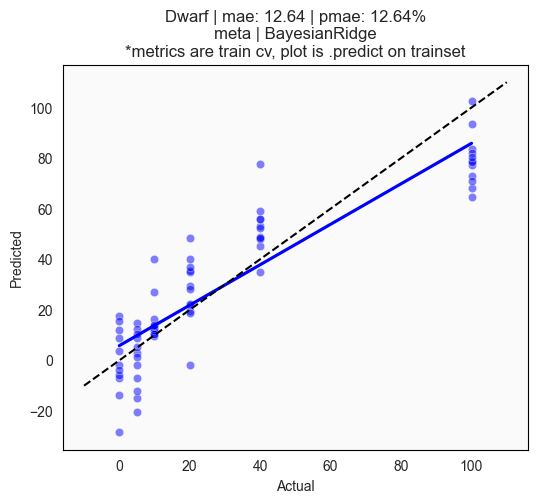

In [99]:
for label in labels:

    print(label)

    list_of_pkl_files = glob.glob(f'../models/predictions_profile/time_split/trainer_{label}_*.pkl')
    model_name = [re.search(r'_([^_]+)\.pkl$', filename).group(1) for filename in list_of_pkl_files]
    loaded_pkl = [pkl.load(open(file, 'rb')) for file in list_of_pkl_files]
    print(model_name)
    
    metrics = [generate_regression_metrics(model,y[label]) for model in loaded_pkl]
    pipelines = [model.get_pipeline() for model in loaded_pkl]
    
    performances = [model.get_best_performance() for model in loaded_pkl]
    print(performances)
    best_performance = np.argmax(np.array(performances)) # argmax, Most positive neg-MSE wins
    # best_performance = 2 # for testing
    
    best_model =  {'name':model_name[best_performance], **metrics[best_performance]}
    best_model_output =  json.dumps(best_model, indent=4)

    X_meta_final = pkl.load(open(output_dir/f'X_meta_final_{label}.pkl', 'rb'))

    dataset_options = {
        'exnir': X_exnir,
        'visnir': X_visnir,
        'meta': X_meta_final, #meta dataset is generated inside training loop
    }

    predictions = pipelines[best_performance].predict(dataset_options[best_model['name']])

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y[label], y=predictions, color='blue', alpha=0.5)
    sns.regplot(x=y[label], y=predictions, scatter=False, color='blue', ci=None)
    plt.plot([y[label].min()-y[label].max()*.1, y[label].max()+y[label].max()*.1], 
             [y[label].min()-y[label].max()*.1, y[label].max()+y[label].max()*.1], 
             color='black', linestyle='--')  # Reference line
    plt.title(f'{label} | mae: {float(best_model["mae"]):.2f} | pmae: {float(best_model["pmae"]):.2f}%\n{best_model["name"]} | {best_model["model"]}\n*metrics are train cv, plot is .predict on trainset')
    plt.xlabel(f'Actual')
    plt.ylabel(f'Predicted')
    plt.savefig(output_dir / f'prederror_{label}_best.png')

    plt.show()
    plt.close()

In [104]:
pipelines[1]

Pipeline(steps=[('BayesianRidge',
                 BayesianRidge(alpha_1=99441.75034868083,
                               alpha_2=99441.75034868083,
                               lambda_1=67490.32387831583,
                               lambda_2=67490.32387831583))])

# predict blinds

In [102]:
y=y_test
X_visnir=X_visnir_test
X_exnir=X_exnir_test
labels_df_og=y_test_og

# predict lot level
y=y.reset_index().drop_duplicates().set_index('lot_id')
labels_df_og=labels_df_og.drop_duplicates().set_index('lot_id')
print(y.shape, X_visnir.shape, X_exnir.shape, labels_df_og.shape)

(7, 6) (28, 191) (28, 89) (7, 7)


Dwarf
['exnir', 'meta', 'visnir']
[-285.3359727537837, -253.4870772802969, -516.4557623096665]
best pipeline is meta
meta workflow


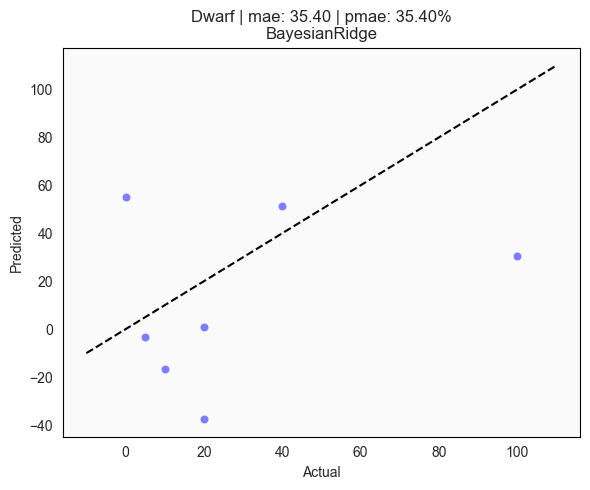

In [103]:
for label in labels:
    print(label)

    output_dir = Path(f"../models/predictions_profile/time_split")
    output_dir.mkdir(exist_ok=True, parents=True)

    # y[label] = y[label].groupby(y.index).mean()
    # y[label] = y[label]
    # y_list = list(y[label])

    list_of_pkl_files = glob.glob(f'../models/predictions_profile/time_split/trainer_{label}_*.pkl')
    model_name = [re.search(r'_([^_]+)\.pkl$', filename).group(1) for filename in list_of_pkl_files]
    loaded_pkl = [pkl.load(open(file, 'rb')) for file in list_of_pkl_files]
    print(model_name)

    metrics = [generate_regression_metrics(model,y[label]) for model in loaded_pkl]
    pipelines = [model.get_pipeline() for model in loaded_pkl]
    pipeline_exnir = pipelines[0] #hardcoded
    pipeline_visnir = pipelines[2] #hardcoded
    
    performances = [model.get_best_performance() for model in loaded_pkl]
    print(performances)
    best_performance = np.argmax(np.array(performances)) # argmax, Most positive neg-MSE wins
    # best_performance = 2 # for testing
    
    best_model =  {'name':model_name[best_performance], **metrics[best_performance]}
    # best_model_output =  json.dumps(best_model, indent=4)
    print(f"best pipeline is {best_model['name']}")

    if best_model['name'] != 'meta':
        print("non-meta workflow")

        dataset_options = {
            'exnir': X_exnir,
            'visnir': X_visnir
        }

        X_input = dataset_options[best_model['name']]
        X_input = X_input.groupby(X_input.index).mean()

        predictions = pipelines[best_performance].predict(X_input)

    else:
        # metamodel flow
        print("meta workflow")
              
        n_classes = 1
        X_meta = pd.DataFrame(0, index=X_visnir.index, columns=pd.RangeIndex(2*n_classes))
        X_meta.loc[:, np.arange(n_classes)] = pipeline_visnir.predict(X_visnir)
        X_meta.loc[:, np.arange(n_classes)+n_classes] = pipeline_exnir.predict(X_exnir)

        pkl_path = os.path.join(output_dir, f"tasteprofile_model_{label}_meta.pkl")
        with open(pkl_path, "rb") as f:
            pipeline_meta = load_pf_legacy_models(f)
        predictions = regression_predict(pipeline_meta, X_meta).iloc[:, 0]

    blinds_MAE = np.mean(np.abs(y[label].values - predictions))
    blinds_pMAE = (blinds_MAE * 100) / abs(y[label].max()-y[label].min()) 

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y[label], y=predictions, color='blue', alpha=0.5)
    plt.plot([y[label].min()-y[label].max()*.1, y[label].max()+y[label].max()*.1], 
             [y[label].min()-y[label].max()*.1, y[label].max()+y[label].max()*.1], 
             color='black', linestyle='--')  # Reference line

    plt.title(f'{label} | mae: {blinds_MAE:.2f} | pmae: {blinds_pMAE:.2f}%\n{best_model["model"]}')
    plt.xlabel(f'Actual')
    plt.ylabel(f'Predicted')
    plt.tight_layout()
    plt.savefig(output_dir / f'prederror_{label}_blind.png')

    plt.show()
    plt.close()

# Training single

In [ ]:
# label = list(y.columns)[0]
# input_y = y[label] # Show example for single column only

In [ ]:
# Run visnir segment
trainer = initialise_trainer(task_type='profile', log=False)
trainer.fit(X_visnir, input_y, kfold=DEFAULT_CV)
score_visnir = trainer.get_best_performance()
best_visnir = trainer.get_pipeline()
metrics_visnir = generate_regression_metrics(trainer, input_y)
trainer_visnir = trainer
base_visnir = [best_visnir]

In [ ]:
# Run exnir segment
trainer = initialise_trainer(task_type='profile', log=False)
trainer.fit(X_exnir, input_y, kfold=DEFAULT_CV)
score_exnir = trainer.get_best_performance()
best_exnir = trainer.get_pipeline()
metrics_exnir = generate_regression_metrics(trainer, input_y)
trainer_exnir = trainer
base_exnir = [best_exnir]

In [ ]:
# Prepare dataset for metamodel segment
datasets = [X_visnir, X_exnir]
estimators = [base_visnir, base_exnir] 
X_meta, y_meta, split_idx = create_meta_datasets_splits(
    estimators=estimators, 
    datasets=datasets, 
    y=input_y, 
    groups=X_visnir.index, 
    outer_cv=DEFAULT_CV, 
    inner_cv=DEFAULT_CV,
    mode='profile',
)

# Run metamodel segment
cv_meta = CustomMetaSplitter(split_idx = split_idx)
trainer = initialise_trainer(task_type='profile', log=False)
trainer.fit(X_meta, y_meta, kfold=cv_meta, search_space=META_REGRESSION_PIPELINES, groups=X_meta.index)
score_meta = trainer.get_best_performance()
metrics_meta = generate_regression_metrics(trainer, input_y)

X_meta_final = generate_metafeatures_profile(datasets, estimators, y=input_y)
best_meta = trainer.get_pipeline()
best_meta.fit(X_meta_final, input_y)
trainer_meta = trainer
print("Done")

In [ ]:
# Review metrics without dumping
import pprint
print(score_visnir, score_exnir, score_meta)

print()
print('visnir')
pprint.pprint(metrics_visnir)

print()
print('exnir')
pprint.pprint(metrics_exnir)

print()
print('metamodel')
pprint.pprint(metrics_meta)



In [ ]:
fig1, fig2 = get_reg_figures(
    model=best_visnir,
    Xtrain=X_visnir,
    ytrain=input_y,
    test=False,
)

# Prediction error fig (Actual vs Predicted)
fig1.update_layout(title='visnir')
fig1.show()

# Residuals fig
fig2.update_layout(title='visnir')
fig2.show()

In [ ]:
fig1, fig2 = get_reg_figures(
    model=best_exnir,
    Xtrain=X_exnir,
    ytrain=input_y,
    test=False,
)

# Prediction error fig (Actual vs Predicted)
fig1.update_layout(title='exnir')
fig1.show()

# Residuals fig
fig2.update_layout(title='exnir')
fig2.show()

In [ ]:
fig1, fig2 = get_reg_figures(
    model=best_meta,
    Xtrain=X_meta_final,
    ytrain=input_y,
    test=False,
)

# Prediction error fig (Actual vs Predicted)
fig1.update_layout(title='meta')
fig1.show()

# Residuals fig
fig2.update_layout(title='meta')
fig2.show()


In [ ]:
# Export Single
# Dump metrics to folder
output_dir = Path("../tests/testdata/predictions_profile/")
output_dir.mkdir(exist_ok=True, parents=True)

_ = model_dump_regression(
    trainer=trainer_visnir, 
    estimator=best_visnir, 
    y=input_y, output_dir=output_dir, suffix="_visnir",
)

_ = model_dump_regression(
    trainer=trainer_exnir, 
    estimator=best_exnir, 
    y=input_y, output_dir=output_dir, suffix="_exnir",
)

_ = model_dump_regression(
    trainer=trainer_meta, 
    estimator=best_meta, 
    y=input_y, output_dir=output_dir, suffix="_meta",
)